In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import itertools
import umap.umap_ as umap
import matplotlib.pyplot as plt
import torch.nn.functional as F

from timeit import default_timer as timer
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import classification_report, make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight
from sklearn import set_config
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm

from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from torch.utils.data import Dataset, DataLoader
from transformers import EsmModel, AutoTokenizer

In [2]:
DIR_PATH = Path("..")

In [3]:
seed = 42

seeds = [42, 89, 101]

In [4]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
    elif torch.backends.mps.is_available(): 
        torch.mps.manual_seed(seed)

    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True  # slow

fix_random(seed)

# Dataset

### loading

In [5]:
data_inpath = DIR_PATH / "datasets/trx_data.csv"

df = pd.read_csv(data_inpath, sep=',')
df.shape

(28601, 5)

In [6]:
df.head()

,id_seq,sequence,start,end,group
0,tr|F0RTT8|F0RTT8_SPHGB,MSEIIVTEANFEQEVLKADKPVLVDFWAPWCGPCKMIAPAIAQLAQ...,7,83,TRX-1
1,tr|A0A7W0KXH4|A0A7W0KXH4_9ACTN,MAIDVTDATFDEQVILASAQQPVVVDLWAEWCGPCRTLGPIIEKVV...,3,84,TRX-1
2,tr|A0A950RKP2|A0A950RKP2_UNCPL,MSSSQTAPIINVGEEDFERAVIEQSHERPVIVDFWAPWCPPCRMLA...,10,91,TRX-1
3,tr|A0A9E3Y983|A0A9E3Y983_9ACTN,MTMIDVTDQTFEAEVLQKSMEVPVVVDLWAPWCGPCRTLGPILDKV...,4,85,TRX-1
4,tr|A0A1V5RS69|A0A1V5RS69_9CHLR,MKSEYVIDVSDATFQTEVINRSRQTPVVVDFWAPWCGPCRMLGPVL...,6,88,TRX-1


Remove possible gaps

In [7]:
df['sequence'] = df['sequence'].apply(lambda x: x.replace('-',''))

In [8]:
print(f"longer sequence length = {df['sequence'].str.len().max()}")
print(f"shorter sequence length = {df['sequence'].str.len().min()}")

longer sequence length = 8256
shorter sequence length = 97


Remove possible duplicates

In [9]:
n_duplicates = df.duplicated(subset='sequence').sum()
print(f"duplicates = {n_duplicates}")

if n_duplicates > 0:
    df = df.drop_duplicates(subset='sequence')
df.shape

duplicates = 0


(28601, 5)

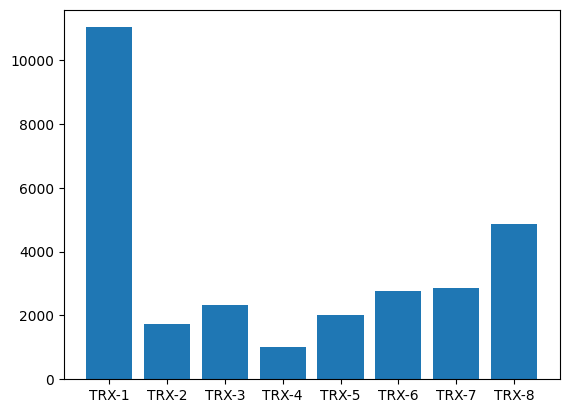

In [10]:
supports = df['group'].value_counts().sort_index(key=lambda x: x.str.extract(r'(\d+)')[0].astype(int))
plt.bar(supports.index, supports)
plt.show()

Splitting 80/10/10

In [11]:

indices = df.index
pd_cat = pd.Categorical(df['group'])

classes = pd_cat.categories
df['label'] = pd_cat.codes

train_idx, test_idx = train_test_split(indices, test_size=0.1, random_state=seed, stratify=df['label'])
train_idx, val_idx = train_test_split(train_idx, test_size=0.1/0.9, random_state=seed, stratify=df.iloc[train_idx]['label'])

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)
test_df = df.iloc[test_idx].reset_index(drop=True)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(22880, 6)
(2860, 6)
(2861, 6)


In [12]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.array(range(len(classes))), y=train_df['label'])
class2weights = {i:w for i,w in enumerate(class_weights)}

### Sequence identity

In [ ]:
from Bio import Align


def compute_score(i, j, s1, s2, aligner):

    return (i, j, aligner.score(s1, s2) / len(min(s1, s2, key=len)))

aligner = Align.PairwiseAligner(match_score=1.0)

n_samples = 500

classes_identity_mtx = defaultdict(lambda: defaultdict())
for c1, c2 in itertools.combinations(classes, 2):
    
    c1_df = train_df[train_df['group'] == c1].reset_index(drop=True)
    c1_df = c1_df.sample(n=n_samples, random_state=seed).reset_index(drop=True)
    
    c2_df = train_df[train_df['group'] == c2].reset_index(drop=True)
    c2_df = c2_df.sample(n=n_samples, random_state=seed).reset_index(drop=True)

    id_mtx = np.eye(c1_df.shape[0], c2_df.shape[0])

    with ThreadPoolExecutor() as executor:

        futures = []
        for i,row1 in c1_df.iterrows():

            for j,row2 in c2_df.iterrows():
                s1, s2 = row1['sequence'], row2['sequence']
                futures.append(executor.submit(compute_score, i, j, s1, s2, aligner))

        for future in futures:
            i, j, score = future.result()
            id_mtx[i][j] = score


    classes_identity_mtx[c1][c2] = pd.DataFrame(id_mtx, index=c1_df['id_seq'].to_list(), columns=c2_df['id_seq'].to_list())

In [49]:
for c1, c2 in itertools.combinations(classes, 2):

    print(f"{c1},{c2}:\n"
          f"Mean sequence id:   {np.mean(classes_identity_mtx[c1][c2].to_numpy()): 4f}\n"
          f"Std deviation id:   {np.std(classes_identity_mtx[c1][c2].to_numpy()): 2f}\n"
          f"Max sequence id :   {np.max(classes_identity_mtx[c1][c2].to_numpy()): 2f}\n"
          f"Min deviation id:   {np.min(classes_identity_mtx[c1][c2].to_numpy()): 2f}\n"
          )


TRX-1,TRX-2:
Mean sequence id:    0.511727
Std deviation id:    0.102286
Max sequence id :    1.000000
Min deviation id:    0.267241

TRX-1,TRX-3:
Mean sequence id:    0.505262
Std deviation id:    0.117441
Max sequence id :    0.972222
Min deviation id:    0.269504

TRX-1,TRX-4:
Mean sequence id:    0.562177
Std deviation id:    0.142590
Max sequence id :    1.000000
Min deviation id:    0.268156

TRX-1,TRX-5:
Mean sequence id:    0.517357
Std deviation id:    0.120015
Max sequence id :    1.000000
Min deviation id:    0.293750

TRX-1,TRX-6:
Mean sequence id:    0.506465
Std deviation id:    0.098860
Max sequence id :    1.000000
Min deviation id:    0.290076

TRX-1,TRX-7:
Mean sequence id:    0.590763
Std deviation id:    0.137766
Max sequence id :    1.000000
Min deviation id:    0.287500

TRX-1,TRX-8:
Mean sequence id:    0.618131
Std deviation id:    0.131685
Max sequence id :    1.000000
Min deviation id:    0.314381

TRX-2,TRX-3:
Mean sequence id:    0.496178
Std deviation id:  

## Data Encoding ESM-2

In [15]:
def get_device():

    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

    print(f'Device: {device}')

    return device

device = get_device()

Device: cuda


In [16]:
esm_v = "facebook/esm2_t12_35M_UR50D"
esm = EsmModel.from_pretrained(esm_v, add_pooling_layer=False)

for param in esm.parameters():
    param.requires_grad = False

tokenizer = AutoTokenizer.from_pretrained(esm_v)

In [ ]:
def esm_embedding(tokenized):
    """
    Returns:
    - CLS vector representation
    - Mean pooled representation vector masking padding
    """
    esm.to(device)
    embedded_mean = list()
    embedded_cls = list()
    non_seq_ids = [tokenizer.token_to_id(token) for token in ["<cls>","<mask>","<eos>","<pad>"]]

    esm.eval()
    with torch.no_grad():
        for input in tokenized:

            input = {k:v.to(device) for k,v in input.items()}
            last_hidd = esm(**input)[0]
            
            embedded_cls.extend(last_hidd[:,0,:].cpu().numpy())

            non_seq_mask = [[id not in non_seq_ids for id in sample] for sample in input['input_ids']]

            embedded_mean.extend(np.mean([last_hidd[i,mask,:].cpu().numpy() for i, mask in enumerate(non_seq_mask)], axis = 1))

    return np.array(embedded_cls), np.array(embedded_mean)


tokenized_train = [tokenizer(seq, max_length=1024, padding='max_length', truncation=True, return_tensors='pt') for seq in train_df['sequence']]
tokenized_val   = [tokenizer(seq, max_length=1024, padding='max_length', truncation=True, return_tensors='pt') for seq in val_df['sequence']]
tokenized_test  = [tokenizer(seq, max_length=1024, padding='max_length', truncation=True, return_tensors='pt') for seq in test_df['sequence']]

train_embedded_cls, train_embedded_mean = esm_embedding(tokenized_train)
val_embedded_cls, val_embedded_mean     = esm_embedding(tokenized_val)
test_embedded_cls, test_embedded_mean   = esm_embedding(tokenized_test)

### Visualization

Mean pooled representaton

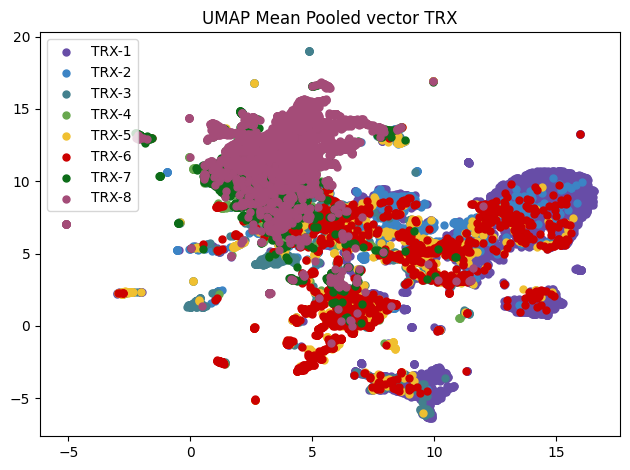

In [36]:
seqs_norm_vec = np.sqrt(np.sum(np.square(train_embedded_mean), axis=1))

mapper = umap.UMAP(n_neighbors=5, metric='cosine')
u = mapper.fit_transform(train_embedded_mean / seqs_norm_vec.reshape(-1,1))

# plt.scatter(u[:,0], u[:,1], c='grey', alpha=0.3 ,s=25)
class2colors = {
             'TRX-1':'#674da7',
             'TRX-2':'#3c84c5',
             'TRX-3':'#43808d',
             'TRX-4':'#68a84e',
             'TRX-5':'#f0c030',
             'TRX-6':'#cc0000',
             'TRX-7':'#0c6c18',
             'TRX-8':'#a44c78'}

for label,c in enumerate(classes):

    filter = train_df['label'] == label
    plt.scatter(u[filter,0], u[filter,1], c=class2colors[c], s=25, label=c)

plt.title('UMAP Mean Pooled vector TRX')
plt.legend()
plt.tight_layout()
plt.show()

CLS vector representation

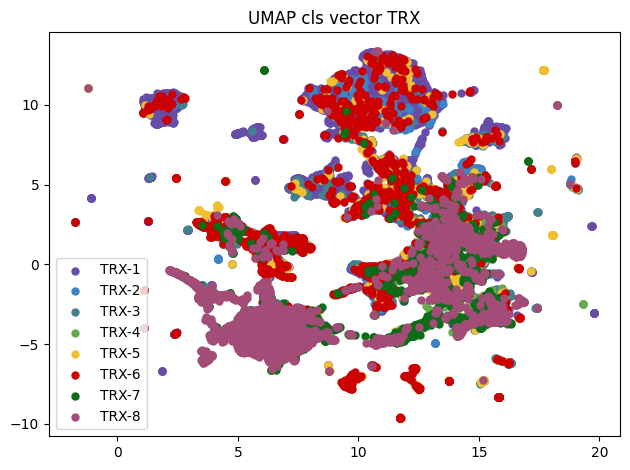

In [37]:
mapper = umap.UMAP(n_neighbors=5, metric='cosine')

# normalization
seqs_norm_vec = np.sqrt(np.sum(np.square(train_embedded_cls), axis=1))
u = mapper.fit_transform(train_embedded_cls / seqs_norm_vec.reshape(-1,1))

# plt.scatter(u[:,0], u[:,1], c='grey', alpha=0.3 ,s=25)
class2colors = {
             'TRX-1':'#674da7',
             'TRX-2':'#3c84c5',
             'TRX-3':'#43808d',
             'TRX-4':'#68a84e',
             'TRX-5':'#f0c030',
             'TRX-6':'#cc0000',
             'TRX-7':'#0c6c18',
             'TRX-8':'#a44c78'}

for label,c in enumerate(classes):

    filter = train_df['label'] == label
    plt.scatter(u[filter,0], u[filter,1], c=class2colors[c], s=25, label=c)

plt.title('UMAP cls vector TRX')
plt.legend()
plt.tight_layout()
plt.show()

# Machine Learning survey

In [17]:
sample_weights = compute_sample_weight(class2weights, train_df['label'])

set_config(enable_metadata_routing=True)
scoring = { 'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average='macro', zero_division=1.0),
            'recall': make_scorer(recall_score, average='macro', zero_division=1.0),
            'f1': make_scorer(f1_score, average='macro', zero_division=1.0)}

scoring = {k:v.set_score_request( sample_weight=True) for k,v in scoring.items()}

cols_to_keep = [col.format(s) for s in ['train','test']
                for col in ['mean_{}_accuracy','mean_{}_precision','mean_{}_recall','mean_{}_f1']]

### SVM classifier

In [18]:
parameters = {'kernel':('linear', 'poly','rbf'), 'C':[5,10,15,20,30]}
svc = svm.SVC().set_fit_request(sample_weight=True)

clf = GridSearchCV(svc, parameters, scoring=scoring, return_train_score=True, refit=False, n_jobs=-1, verbose=2)
clf.fit(train_embedded_mean, train_df['label'], sample_weight=sample_weights)
svc_df = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[CV] END ..................................C=10, kernel=poly; total time= 2.6min
[CV] END ................................C=15, kernel=linear; total time= 4.3min
[CV] END ................................C=10, kernel=linear; total time= 4.3min
[CV] END ................................C=15, kernel=linear; total time= 4.3min
[CV] END ................................C=10, kernel=linear; total time= 4.4min
[CV] END .................................C=5, kernel=linear; total time= 4.4min
[CV] END ................................C=10, kernel=linear; total time= 4.5min
[CV] END .................................C=5, kernel=linear; total time= 4.5min
[CV] END .................................C=5, kernel=linear; total time= 4.4min
[CV] END ................................C=10, kernel=linear; total time= 4.6min
[CV] END ................................C=10, kernel=linear; total time= 4.6min
[CV] END .................................C=5, kernel=linear; total time= 4.5min
[CV] END ...................

In [32]:
best_idx = svc_df['rank_test_f1'].idxmax()
best_params = svc_df['params'][best_idx]

print(f"best_params: {best_params}\n")
svc_df[cols_to_keep].iloc[best_idx]

best_params: {'C': 5, 'kernel': 'rbf'}



mean_train_accuracy     0.838941
mean_train_precision    0.839016
mean_train_recall       0.838941
mean_train_f1           0.838218
mean_test_accuracy      0.783643
mean_test_precision     0.783804
mean_test_recall        0.783641
mean_test_f1            0.782906
Name: 2, dtype: float64

In [34]:
svc = svm.SVC(**best_params)
svc.fit(train_embedded_mean, train_df['label'], sample_weight=sample_weights)

y_val_pred = svc.predict(val_embedded_mean)
y_test_pred = svc.predict(test_embedded_mean)

In [36]:
print("validation set report:")
print(classification_report(val_df['label'], y_val_pred, target_names=classes))

validation set report:
              precision    recall  f1-score   support

       TRX-1       0.98      0.90      0.94      1103
       TRX-2       0.67      0.86      0.75       173
       TRX-3       0.84      0.87      0.85       233
       TRX-4       0.56      0.74      0.63       102
       TRX-5       0.65      0.67      0.66       200
       TRX-6       0.69      0.73      0.71       275
       TRX-7       0.75      0.79      0.77       287
       TRX-8       0.96      0.86      0.90       487

    accuracy                           0.84      2860
   macro avg       0.76      0.80      0.78      2860
weighted avg       0.85      0.84      0.84      2860



In [37]:
print("test set report:")
print(classification_report(test_df['label'], y_test_pred, target_names=classes))

test set report:
              precision    recall  f1-score   support

       TRX-1       0.97      0.91      0.94      1103
       TRX-2       0.69      0.90      0.78       173
       TRX-3       0.87      0.83      0.85       233
       TRX-4       0.53      0.83      0.65       102
       TRX-5       0.68      0.61      0.64       200
       TRX-6       0.64      0.72      0.68       276
       TRX-7       0.77      0.74      0.75       287
       TRX-8       0.93      0.88      0.90       487

    accuracy                           0.84      2861
   macro avg       0.76      0.80      0.77      2861
weighted avg       0.85      0.84      0.84      2861



### XGBoost classifier

In [23]:
parameters = {  'n_estimators':     [25,50],
                'learning_rate':    [0.05, 0.01],
                'max_depth':        [3,5,8],
                'random_state':     [seed]
                }

gbc = GradientBoostingClassifier().set_fit_request(sample_weight=True)

clf = GridSearchCV(gbc, parameters, scoring=scoring, return_train_score=True, refit=False, n_jobs=-1, verbose=3)
clf.fit(train_embedded_mean, train_df['label'], sample_weight=sample_weights)
gbc_df = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, random_state=42; accuracy: (test=0.602) f1: (test=0.599) precision: (test=0.598) recall: (test=0.602) total time= 5.8min
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=10, random_state=42; accuracy: (test=0.608) f1: (test=0.604) precision: (test=0.603) recall: (test=0.608) total time= 5.9min
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, random_state=42; accuracy: (test=0.613) f1: (test=0.610) precision: (test=0.610) recall: (test=0.613) total time= 5.9min
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=10, random_state=42; accuracy: (test=0.592) f1: (test=0.588) precision: (test=0.587) recall: (test=0.592) total time= 6.0min
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, random_state=42; accuracy: (test=0.616) f1: (test=0.613) precision: (test=0.613) recall: (test=0.616) total time= 6.2min
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=10, random_state=42; accura

In [ ]:
best_idx = gbc_df['rank_test_f1'].idxmax()
best_params = gbc_df['params'][best_idx]

print(f"best_params: {best_params}\n")
svc_df[cols_to_keep].iloc[best_idx]

In [ ]:
gbc = GradientBoostingClassifier(**best_params)
gbc.fit(train_embedded, train_df['label'], sample_weight=sample_weights)

y_val_pred = gbc.predict(val_embedded_mean)
y_test_pred = gbc.predict(test_embedded_mean)

In [ ]:
print("validation set report:")
print(classification_report(val_df['label'], y_val_pred, labels=classes))

In [67]:
print("test set report:")
print(classification_report(test_df['label'], y_test_pred, labels=classes))

test set report:


NameError: name 'y_test_pred' is not defined

# Deep Learning survey

In [17]:
class EsmDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame, tokenizer=None):
        
        self.X = dataframe['sequence']
        
        self.y = None
        if 'label' in dataframe.columns:
            self.y = torch.LongTensor(dataframe['label'])
        
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.X) 

    def __getitem__(self, idx):

        batch_x = self.X[idx]
        
        if self.tokenizer is not None:

            token_dict = self.tokenizer(batch_x, max_length=1024, padding='max_length', truncation=True, return_tensors='pt')
            batch_x = {k:v.squeeze(0) for k,v in token_dict.items()}
            
        batch_y = None
        if self.y is not None:
            batch_y = self.y[idx]
            
        return batch_x, batch_y

In [18]:
# remove cls token
train_ds = EsmDataset(train_df, tokenizer)
train_loader = DataLoader(
    train_ds, batch_size=16, shuffle=True, pin_memory=True, num_workers=4
    )

val_ds = EsmDataset(val_df, tokenizer)
val_loader = DataLoader(
    val_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=4
    )

test_ds = EsmDataset(test_df, tokenizer)
test_loader = DataLoader(
    test_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=4
    )

### Training and Eval utils

In [19]:
class EvalMetrics:

    def __init__(self, n_labels, c_weight=None):

        self.num_labels = n_labels
        self.class2weight = c_weight

        self.accuracy = []

        self.f1score = []

        self.y_true = []
        self.y_pred = []

    def clear(self):

        self.y_true = []
        self.y_pred = []

    def step(self):
        """
        Calculate and collect metrics
        """
        report = self.compute()

        self.accuracy.append(report['accuracy'])
        self.f1score.append(report['f1_score'])

        self.clear()

    def update(self, y_true, y_pred):

        self.y_true.extend(y_true)
        self.y_pred.extend(y_pred)

    def compute(self) -> defaultdict:
        """
        Compute two evaluation metrics:
            - f1score
            - accuracy
        All metrics are inversely frequency weighted with sklearn.utils.compute_class_weight
        """

        sample_weights = None
        if self.class2weight is not None:
            sample_weights = compute_sample_weight(self.class2weight, self.y_true)
        
        report = defaultdict()

        report['accuracy'] = accuracy_score(
            self.y_true, self.y_pred, sample_weight=sample_weights
            )
        report['f1_score'] = f1_score(
            self.y_true, self.y_pred, average='macro', sample_weight=sample_weights, zero_division=1.0
            )

        return report

    

In [20]:
def save_ckpt(model, ofpath: Path):

    ofpath.parent.mkdir(parents=True, exist_ok=True)

    torch.save(model.state_dict(), ofpath)

def load_ckpt(model: nn.Module, ofpath: Path):

    ckpt = torch.load(ofpath, weights_only=True)

    model.load_state_dict(ckpt)

    return model

In [21]:
def train(model, epochs, criterion, optimizer, scheduler, train_loader, val_loader, log_interval, odir="results", save=False, verbose:int = 1):

    len_train = len(train_loader)
    model.to(device)

    def nest_dict():
        return defaultdict(nest_dict)
    history = defaultdict(nest_dict)

    history['train']['loss'] = []
    history['val']['loss'] = []
    history['train']['accuracy'] = []
    history['val']['accuracy'] = []

    metrics_train = EvalMetrics(len(classes), class2weights)
    metrics_val = EvalMetrics(len(classes), class2weights)

    loop_start = timer()

    best_f1 = 0.0
    best_model_path = ""
    
    patience_counter = 0
    patience = 1

    lr = optimizer.state_dict()['param_groups'][0]['lr']
    
    for epoch in range(epochs):

        num_samples = 0

        loss_train = 0.0

        if verbose > 1:
            pbar = tqdm(range(len_train))
            iterator = zip(pbar, train_loader)
        else:
            iterator = enumerate(train_loader)

        model.train()
        for i, (inputs, targets) in iterator:

            optimizer.zero_grad(set_to_none=True)

            inputs = {k:v.to(device) for k,v in inputs.items()}
            targets = targets.to(device)

            logits = model(inputs)

            loss = criterion(logits.view(-1, len(classes)), targets.view(-1))

            loss_train += loss.item() * len(targets)
            
            loss.backward()

            optimizer.step()

            if scheduler is not None and isinstance(scheduler, torch.optim.lr_scheduler.LambdaLR):
                
                scheduler.step()
                lr = optimizer.state_dict()['param_groups'][0]['lr']


            with torch.no_grad():
                
                num_samples += len(targets)

                y_probs = F.softmax(logits, dim=-1)
                y_pred = torch.argmax(y_probs, dim=-1).cpu().numpy()

                metrics_train.update(targets.cpu().numpy(), y_pred)

                if log_interval > 0 and i % log_interval == 0 and verbose > 1:

                    lr = optimizer.param_groups[0]['lr']

                    report = metrics_train.compute()
                    pbar.set_postfix({
                        'TRAIN '
                        'lr': lr,
                        'loss': np.round(loss_train/num_samples, 5),
                        'accuracy': np.round(report['accuracy'],4),
                        'f1': np.round(report['f1_score'],4)
                        })

                    pbar.update(0)

        loss_train /= num_samples

        history['train']['loss'].append(loss_train)
        metrics_train.step()


        loss_val = evaluate(model, criterion, metrics_val, val_loader, verbose)

        history['val']['loss'].append(loss_val)
        metrics_val.step()

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(loss_val if val_loader else loss_train)
            elif not isinstance(scheduler, torch.optim.lr_scheduler.LambdaLR):
                scheduler.step()
            lr = optimizer.state_dict()['param_groups'][0]['lr']

        if metrics_val.f1score[epoch] > best_f1:

            best_f1 = metrics_val.f1score[epoch]
            patience_counter = 0
            
            if save:
                fname = f"epoch-{epoch}_f1-{best_f1:.2f}.pt"
                save_ckpt(model, odir/fname)
                best_model_path = odir/fname
        else:
            patience_counter += 1


        if verbose > 0 or (not verbose and epoch==epochs-1) or patience_counter > patience:
            print(  f'Epoch: {epoch+1}'
                    f' Lr: {lr :4f}'
                    f' Train/Val: Loss = [{loss_train :.4f},{loss_val :.4f}]'
                    f' Accuracy = [{metrics_train.accuracy[epoch] :.4f},{metrics_val.accuracy[epoch] :.4f}]'
                    f' F1 = [{metrics_train.f1score[epoch] :.4f},{metrics_val.f1score[epoch] :.4f}]'
                    )
            
        if patience_counter > patience:
            break

    loop_end = timer()

    tot_time = loop_end - loop_start

    print(f"Total time (s): {tot_time}",'\n')

    history['train']['accuracy'] = metrics_train.accuracy
    history['train']['f1_score'] = metrics_train.f1score
    history['val']['accuracy'] = metrics_val.accuracy
    history['val']['f1_score'] = metrics_val.f1score
    history['best_model_path'] = best_model_path
    
    return history

@torch.no_grad()
def evaluate(model, criterion, metrics: EvalMetrics, loader, verbose):

    num_samples = 0

    tot_loss = 0.0

    pbar = tqdm(range(len(loader))) if verbose > 1 else None

    iterator = zip(pbar, loader) if verbose > 1 else enumerate(loader)

    model.eval()
    for i, (inputs, targets) in iterator:


        inputs = {k:v.to(device) for k,v in inputs.items()}
        targets = targets.to(device)

        logits = model(inputs)

        loss = criterion(logits.view(-1, len(classes)), targets.view(-1))

        tot_loss += loss.item() * len(targets)

        num_samples += len(targets)

        y_probs = F.softmax(logits, dim=-1)
        y_pred = torch.argmax(y_probs, dim=-1).cpu().numpy()

        metrics.update(targets.cpu().numpy(), y_pred)

    tot_loss /= num_samples
    return loss

In [22]:
from transformers import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

def get_scheduler(optimizer, lr_scheduler, train_steps, factor: float = None):

    if lr_scheduler == 'warmuplinear':

        return get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(train_steps * 0.1), num_training_steps=train_steps)
    
    elif lr_scheduler == 'warmupcos':

        return get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(train_steps * 0.1), num_training_steps=train_steps)
    
    elif lr_scheduler == 'onplateau':

        if factor is not None:
            return torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', patience=1, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=1e-7, factor=factor
                )
        else:
            return torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', patience=1, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=1e-7
                )
    
    elif lr_scheduler == 'exponential':

        return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=factor if factor else 0.1)
    else:
        return None

def fit(model, epochs, lr, optimizer, criterion, options:dict = None, train_name='', save=False, verbose=1):

    optimizer_params = dict()
    if options is not None:
        optimizer_params = {key: options[key] for key in ['weight_decay'] if key in options}

    optimizer = optimizer(model.parameters(), lr, **optimizer_params)
    
    scheduler = None
    if options is not None:
            scheduler = get_scheduler(
                optimizer, options.get('lr_scheduler'), len(train_loader) * epochs, options.get('factor')
                )

    odir = DIR_PATH / "results" / train_name

    return train(model, epochs, criterion, optimizer, scheduler, train_loader, val_loader, 50, odir, save, verbose)

In [23]:
from collections import OrderedDict


def grid_search(model, params: OrderedDict, **kwargs):
    """
    Hyperparams search using F1 as performance criterion.
    Return:
        - Best f1 score
        - Best hyperparams
    """

    def params_to_str(comb):
        return ' - '.join([f'{k}: {v}' for k, v in comb.items()])

    mandatory_params = ['lr', 'epochs', 'optimizer', 'criterion']

    params_name = list(params.keys())
    params_values = params.values()

    all_params = params_name + list(kwargs.keys())
    # check mandatory parameters
    if any(p not in all_params for p in mandatory_params):

        print(f"Missing one of this parameters: {mandatory_params}")
        return
    
    list_combination = list(itertools.product(*params_values))
    combination_dicts = [OrderedDict(zip(params_name, c)) for c in list_combination]

    best_combination = None
    best_f1 = 0.0
    best_epoch = 0
    
    for combination in combination_dicts:

        print(params_to_str(combination))

        for k,v in kwargs.items():
            combination[k] = v
        
        history = fit(
            model(device, combination),
            combination['epochs'], combination['lr'], combination['optimizer'], combination['criterion'], combination
            )

        for key in kwargs.keys():
            combination.pop(key, None)
            
        if best_f1 < max(history['val']['f1_score']):
            best_f1 = max(history['val']['f1_score'])
            best_epoch = np.argmax(history['val']['f1_score']) + 1 
            best_combination = combination

    print(f"Best hyperparameters: {params_to_str(best_combination)}"
          '\n'
          f"at epoch {best_epoch} with f1 score = {best_f1}")

    return best_f1, best_combination, best_epoch


def evaluate_seed(model, epochs, criterion, params: OrderedDict, seeds):
    """
    Validate and test the model for n seeds. Selection criterion
    of best seed is f1 score.
    Return:
        - Report collecting all metrics for seeds
        - The seed with best performance
    """
    def nest_dict():
        return defaultdict(nest_dict)
    
    seed_reports = defaultdict(nest_dict)

    best_seed = None
    best_f1 = 0.0
    best_model_path = ""

    # check mandatory parameters
    mandatory_params = ['lr', 'optimizer']

    if any(key not in params for key in mandatory_params):

        print(f"Missing one of this parameters: {mandatory_params}")
        return
    
    for random_seed in seeds:

        print(f"Seed: {random_seed}")
        fix_random(random_seed)

        seed_model = model(device, params)

        train_name = f"{seed_model.__class__.__name__}-{random_seed}"

        history = fit(
            seed_model,
            epochs, params['lr'], params['optimizer'], criterion, params, train_name=train_name, save=True, verbose=1
            )

        best_epoch = np.argmax(history['val']['f1_score'])

        seed_reports['val'][random_seed] = history

        print(f'Best epoch={best_epoch+1} Loss = [{history["val"]["loss"][best_epoch] :.4f}] '
              '\n'
              f'F1 = [{history["val"]["f1_score"][best_epoch] :.4f}]'
              '\n')

        if best_f1 < history['val']['f1_score'][best_epoch]:
            best_f1 = history['val']['f1_score'][best_epoch]
            best_seed = random_seed
            best_model_path = history['best_model_path']

        #######################
        # Test set evaluation #
        #######################

        seed_model = load_ckpt(seed_model, history['best_model_path'])
        
        metrics_test = EvalMetrics(len(classes), class2weights)

        test_loss = evaluate(seed_model, criterion, metrics_test, test_loader, verbose=False)

        report_test = metrics_test.compute()

        seed_reports['test'][random_seed] = report_test

        print(f'Test seed:{random_seed}'
              '\n'
              f'Loss = [{test_loss :.4f}] '
              '\n'
              f'Accuracy = [{report_test["accuracy"] :.4f}]'
              '\n'
              f'F1 = [{report_test["f1_score"] :.4f}]'
              '\n')

    return seed_reports, best_seed, best_model_path

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay


def display_aggregate_metrics(report):

    print('Aggregate Metrics \n'
          
        f"accuracy: {100 * np.mean([report[random_seed]['accuracy'] for random_seed in report.keys()]) :.4f}%"
        f" ± {100 * np.std([report[random_seed]['accuracy'] for random_seed in report.keys()]) :.4f}%"
        '\n'
        f"f1 score: {100 * np.mean([report[random_seed]['f1_score'] for random_seed in report.keys()]) :.4f}%"
        f" ± {100 * np.std([report[random_seed]['f1_score'] for random_seed in report.keys()]) :.4f}%"
        )

def plot_cm(y_true, y_pred, title, labels=None):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize='true')
    plt.title(title)
    plt.show()
    plt.clf()

### 1-D Conv classifier

In [25]:
class ConvESM(nn.Module):

    def __init__(self, device, options):

        super().__init__()

        self.esm = EsmModel.from_pretrained(esm_v, add_pooling_layer=False)
        self.esm.to(device)

        for param in self.esm.parameters():
            param.requires_grad = False

        hidd_size = self.esm.config.hidden_size

        in_size = hidd_size
        out_size = options['hidd_size']

        self.conv_layers = nn.ModuleList(
            [nn.Conv1d(in_size, out_size, kernel_size=3, padding=1)] * options['n_conv'] +
            [nn.Conv1d(in_size, out_size, kernel_size=5, padding=2)] * options['n_conv'] +
            [nn.Conv1d(in_size, out_size, kernel_size=7, padding=3)] * options['n_conv'] 
        )

        self.dropout = nn.Dropout(options['dropout'])
        self.fc = nn.Linear(3 * (out_size * options['n_conv']), len(classes))

    def init_weights(self):

        for layer in self.conv_layers:
            torch.nn.init.xavier_uniform_(layer.weight)

        torch.nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, inputs):
        

        last_hidd = self.esm(**inputs)[0]
        
        # get only sequence tokens (exclude cls and eos)
        x = last_hidd[:,1:,:].permute(0,2,1)

        # multi-channel duplicate the input keeping one static and the other one fine-tuned (https://arxiv.org/pdf/1408.5882)
        x_static = x.clone().detach()
        
        # Pooled feature map created taking the max for each feature map
        c = list()
        for layer in self.conv_layers:
            
            z_static_i = F.relu(layer(x_static))
            z_i = F.relu(layer(x))
            z = z_i + z_static_i

            cmax, _ = torch.max(z, dim=-1)        
            c.append(cmax)

        x = torch.concat(c, dim=-1)

        x = self.dropout(x)
        logits = self.fc(x)

        return logits

**First round hyperparams tuning**

Find best architecture parameters

In [23]:
params = OrderedDict({
    'dropout' : [0.2, 0.5],
    'n_conv': [32,64],
    'hidd_size': [128,256]

})

fix_random(seed)

model_criterion = nn.CrossEntropyLoss(torch.tensor(class_weights, dtype=torch.float32).to(device))
best_loss, best_arch_params, best_epoch = grid_search(ConvESM, params, lr=5e-4, epochs=5, optimizer=torch.optim.SGD, criterion=model_criterion)

dropout: 0.2 - n_conv: 32 - hidd_size: 128
Epoch: 1 Lr: 0.000500 Train/Val: Loss = [0.9589,0.4841] Accuracy = [0.6388,0.7736] F1 = [0.6360,0.7757]
Epoch: 2 Lr: 0.000500 Train/Val: Loss = [0.5279,0.4210] Accuracy = [0.8049,0.8384] F1 = [0.8038,0.8360]
Epoch: 3 Lr: 0.000500 Train/Val: Loss = [0.4332,0.3617] Accuracy = [0.8409,0.8427] F1 = [0.8404,0.8439]
Epoch: 4 Lr: 0.000500 Train/Val: Loss = [0.3820,0.3551] Accuracy = [0.8595,0.8489] F1 = [0.8589,0.8507]
Epoch: 5 Lr: 0.000500 Train/Val: Loss = [0.3351,0.3611] Accuracy = [0.8761,0.8554] F1 = [0.8757,0.8558]
Total time (s): 7159.524011075497 

dropout: 0.2 - n_conv: 32 - hidd_size: 256
Epoch: 1 Lr: 0.000500 Train/Val: Loss = [1.0244,0.4147] Accuracy = [0.6259,0.7894] F1 = [0.6253,0.7886]
Epoch: 2 Lr: 0.000500 Train/Val: Loss = [0.5332,0.2735] Accuracy = [0.8050,0.8360] F1 = [0.8042,0.8367]
Epoch: 3 Lr: 0.000500 Train/Val: Loss = [0.4339,0.3379] Accuracy = [0.8379,0.8434] F1 = [0.8374,0.8412]
Epoch: 4 Lr: 0.000500 Train/Val: Loss = [0.372

**Second round hyperparams tuning**

Find best training parameters

In [32]:
params = OrderedDict({
    'lr' : [1e-3,1e-4],
    'weight_decay' : [0.0, 0.01],
    'optimizer': [torch.optim.SGD, torch.optim.AdamW],
    'lr_scheduler': [None,'warmupcosine'],
})

fix_random(seed)

model_criterion = nn.CrossEntropyLoss(torch.tensor(class_weights, dtype=torch.float32).to(device))
best_loss, best_train_params, best_epoch = grid_search(ConvESM, params, epochs=5, criterion=model_criterion, **best_arch_params)

lr: 0.001 - weight_decay: 0.0 - optimizer: <class 'torch.optim.sgd.SGD'> - lr_scheduler: None
Epoch: 1 Lr: 0.001000 Train/Val: Loss = [1.1302,0.5328] Accuracy = [0.7168,0.7374] F1 = [0.7158,0.7480]
Epoch: 2 Lr: 0.001000 Train/Val: Loss = [0.3909,0.2898] Accuracy = [0.8554,0.8454] F1 = [0.8550,0.8458]
Epoch: 3 Lr: 0.001000 Train/Val: Loss = [0.2921,0.1345] Accuracy = [0.8941,0.8676] F1 = [0.8939,0.8685]
Epoch: 4 Lr: 0.001000 Train/Val: Loss = [0.2298,0.2188] Accuracy = [0.9166,0.8588] F1 = [0.9165,0.8573]
Epoch: 5 Lr: 0.001000 Train/Val: Loss = [0.1829,0.1601] Accuracy = [0.9360,0.8715] F1 = [0.9359,0.8734]
Total time (s): 12881.665603917092 

lr: 0.001 - weight_decay: 0.0 - optimizer: <class 'torch.optim.sgd.SGD'> - lr_scheduler: warmupcosine
Epoch: 1 Lr: 0.001000 Train/Val: Loss = [1.1480,0.3474] Accuracy = [0.7160,0.8161] F1 = [0.7154,0.8190]
Epoch: 2 Lr: 0.001000 Train/Val: Loss = [0.3838,0.7811] Accuracy = [0.8604,0.7919] F1 = [0.8601,0.7955]
Epoch: 3 Lr: 0.001000 Train/Val: Loss =

In [27]:
best_overall_params = dict(**best_arch_params, **best_train_params)
best_overall_params

{'dropout': 0.2,
 'n_conv': 64,
 'hidd_size': 256,
 'lr': 0.001,
 'weight_decay': 0.01,
 'optimizer': torch.optim.sgd.SGD,
 'lr_scheduler': 'warmupcosine'}

In [30]:
report_metrics, best_seed, best_model_path = evaluate_seed(ConvESM, epochs=10, criterion=model_criterion, params=best_overall_params, seeds=seeds)

print(f"Best seed: {best_seed}, Best model path: {best_model_path}")

Seed: 42


In [ ]:
print('Validation')
display_aggregate_metrics(report_metrics['val'])

print('Test')
display_aggregate_metrics(report_metrics['test'])